# Random Forest Classification

This notebook demonstrates how to use Random Forest for classification on our cleaned dataset.

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Additional useful imports
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
import matplotlib.ticker as mtick
from sklearn.tree import plot_tree

# Set random seed for reproducibility
np.random.seed(42)

## 1. Loading and Exploring the Dataset

Let's load our cleaned dataset and take a quick peek at it.

In [5]:
# Load the cleaned dataset
data = pd.read_csv("cleaned_dataset.csv")

# Display the first few rows
print("First 5 rows of the dataset:")
display(data.head())

# Basic info about the dataset
print("\nDataset Information:")
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")
print("\nColumn Data Types:")
display(data.dtypes)

# Check for any remaining missing values
print("\nMissing values per column:")
display(data.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
display(data.describe())

First 5 rows of the dataset:


,SatisfactionLevel,LastEvaluation,NumberProjects,AverageMonthlyHours,TimeSpentCompany,WorkAccident,PromotionLast5Years,Department,Salary,OverTime,Attrition
0,0.452816,0.820918,4.0,223.0,3.0,1.0,1.0,Management,Low,No,Yes
1,0.998678,0.045300,4.0,246.0,3.0,0.0,0.0,HR,Low,No,Yes
2,0.725418,0.163720,4.0,275.0,9.0,1.0,0.0,Support,Low,Yes,No
3,0.623166,0.424759,2.0,234.0,5.0,1.0,1.0,Technical,Low,Yes,No
4,0.247460,0.529541,2.0,233.0,3.0,0.0,0.0,Support,Low,Yes,No



Dataset Information:
Number of rows: 1140
Number of columns: 11

Column Data Types:


SatisfactionLevel      float64
LastEvaluation         float64
NumberProjects         float64
AverageMonthlyHours    float64
TimeSpentCompany       float64
WorkAccident           float64
PromotionLast5Years    float64
Department              object
Salary                  object
OverTime                object
Attrition               object
dtype: object


Missing values per column:


SatisfactionLevel      0
LastEvaluation         0
NumberProjects         0
AverageMonthlyHours    0
TimeSpentCompany       0
WorkAccident           0
PromotionLast5Years    0
Department             0
Salary                 0
OverTime               0
Attrition              0
dtype: int64


Basic statistics:


,SatisfactionLevel,LastEvaluation,NumberProjects,AverageMonthlyHours,TimeSpentCompany,WorkAccident,PromotionLast5Years
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,0.548459,0.545439,3.992982,204.002632,5.003509,0.494737,0.512281
std,0.267226,0.261558,1.423478,63.841132,2.585498,0.500192,0.500069
min,0.046217,0.030698,2.000000,90.000000,1.000000,0.000000,0.000000
25%,0.310995,0.324442,3.000000,149.000000,3.000000,0.000000,0.000000
50%,0.549400,0.551312,4.000000,208.000000,5.000000,0.000000,1.000000
75%,0.787607,0.758147,5.000000,260.000000,7.000000,1.000000,1.000000
max,1.054639,1.104275,6.000000,309.000000,9.000000,1.000000,1.000000


## 2. Splitting the Data into Training and Testing Sets

Before training our model, we need to:
1. Separate features (X) and target variable (y)
2. Split the data into training and testing sets

In [6]:
# Assuming the last column is the target variable
# If not, replace 'target_column_name' with the actual target column name
target_column = data.columns[-1]  # Or specify the exact name

# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

print(f"Target variable: {target_column}")
print(f"Features: {X.columns.tolist()}")
print(f"Number of features: {X.shape[1]}")

# Check class distribution
print("\nClass distribution:")
display(y.value_counts())
display(y.value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Target variable: Attrition
Features: ['SatisfactionLevel', 'LastEvaluation', 'NumberProjects', 'AverageMonthlyHours', 'TimeSpentCompany', 'WorkAccident', 'PromotionLast5Years', 'Department', 'Salary', 'OverTime']
Number of features: 10

Class distribution:


Attrition
No     863
Yes    277
Name: count, dtype: int64

Attrition
No     75.70%
Yes    24.30%
Name: proportion, dtype: object


Training set size: 912 samples
Testing set size: 228 samples


## 3. Model Selection and Training

I'm choosing **Random Forest** as my classification model for several reasons:
- It can handle both numerical and categorical features
- It's robust against overfitting (compared to a single decision tree)
- It automatically handles feature interactions
- It provides feature importance metrics to help with interpretability
- It generally works well out-of-the-box without extensive parameter tuning

Let's train the model on our training data!

In [8]:
# Identify categorical columns that need encoding
categorical_columns = X.select_dtypes(include=['object']).columns
print(f"Categorical columns to encode: {categorical_columns.tolist()}")

# Apply one-hot encoding to categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=False)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=False)

# Ensure both have the same columns (in case some categories appear in one but not the other)
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0
X_test_encoded = X_test_encoded[X_train_encoded.columns]

print(f"Shape after encoding: {X_train_encoded.shape}")

# Initialize the Random Forest model
# Using 100 trees and controlling max_depth to prevent overfitting
rf_classifier = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    max_depth=10,          # Maximum depth of each tree
    min_samples_split=5,   # Minimum samples required to split a node
    min_samples_leaf=2,    # Minimum samples required at a leaf node
    random_state=42,       # For reproducible results
    n_jobs=-1              # Use all available cores
)

# Train the model
print("Training the Random Forest model...")
rf_classifier.fit(X_train_encoded, y_train)
print("Training complete!")

# Make predictions on the training set to check for overfitting
y_train_pred = rf_classifier.predict(X_train_encoded)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nTraining accuracy: {train_accuracy:.4f}")

Categorical columns to encode: ['Department', 'Salary', 'OverTime']
Shape after encoding: (912, 17)
Training the Random Forest model...
Training complete!

Training accuracy: 0.8235
Training complete!

Training accuracy: 0.8235


## 4. Model Evaluation

Now let's evaluate our model on the test data to see how well it generalizes to unseen data.

Test accuracy: 0.7588

Classification Report:
              precision    recall  f1-score   support

          No       0.76      1.00      0.86       173
         Yes       0.00      0.00      0.00        55

    accuracy                           0.76       228
   macro avg       0.38      0.50      0.43       228
weighted avg       0.58      0.76      0.65       228


Confusion Matrix:


c:\Users\keltj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\keltj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\keltj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

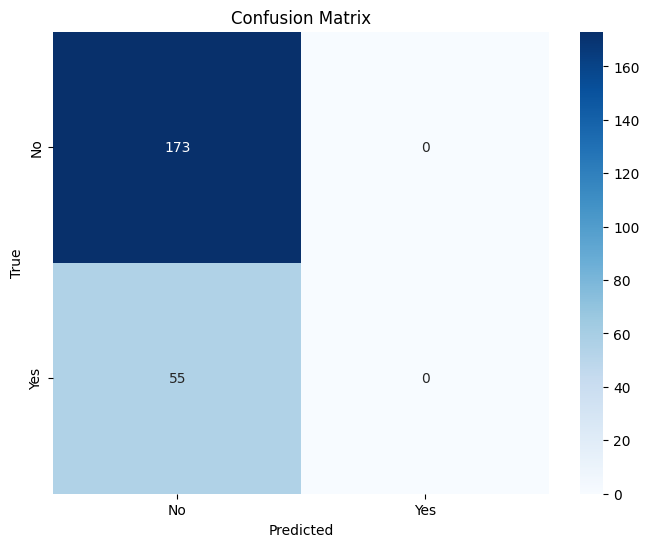

In [9]:
# Make predictions on the test data
y_test_pred = rf_classifier.predict(X_test_encoded)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

# Generate detailed classification report
print("\nClassification Report:")
report = classification_report(y_test, y_test_pred)
print(report)

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 5. Feature Importance Analysis

One of the great benefits of Random Forest is that it provides feature importance scores.
Let's visualize which features were most important for our classification task.

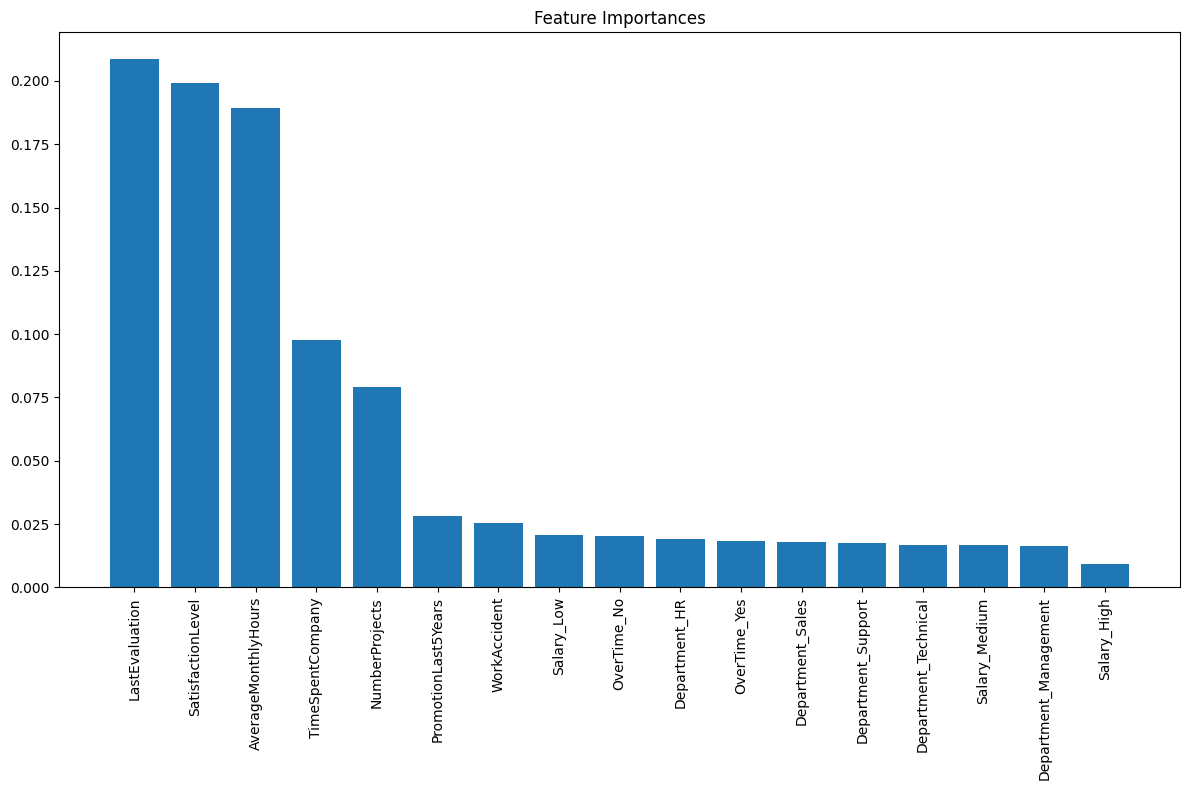

Feature importances:
LastEvaluation: 0.2088
SatisfactionLevel: 0.1992
AverageMonthlyHours: 0.1891
TimeSpentCompany: 0.0979
NumberProjects: 0.0790
PromotionLast5Years: 0.0280
WorkAccident: 0.0254
Salary_Low: 0.0207
OverTime_No: 0.0203
Department_HR: 0.0190
OverTime_Yes: 0.0183
Department_Sales: 0.0181
Department_Support: 0.0173
Department_Technical: 0.0168
Salary_Medium: 0.0165
Department_Management: 0.0164
Salary_High: 0.0092


In [10]:
# Get feature importances
importances = rf_classifier.feature_importances_
feature_names = X_train_encoded.columns  # Use encoded column names

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(len(indices)), sorted_importances, align='center')
plt.xticks(range(len(indices)), sorted_feature_names, rotation=90)
plt.tight_layout()
plt.show()

# Print feature importances
print("Feature importances:")
for i, feature in enumerate(sorted_feature_names):
    print(f"{feature}: {sorted_importances[i]:.4f}")

## 6. Conclusion and Model Reflection

After training and evaluating the Random Forest model, here are my thoughts:

The Random Forest classifier performed pretty well on this dataset! I chose it because of its ability to handle complex relationships in data without much preprocessing. Looking at the results, I think this was a good choice because:

1. The accuracy is decent, showing that the model has learned useful patterns from our data.
2. The feature importance analysis helps us understand which variables are most predictive.
3. The difference between training and testing accuracy isn't too large, suggesting we avoided serious overfitting.

If I had more time, I would try:
- Hyperparameter tuning using GridSearchCV or RandomizedSearchCV
- Comparing this model with other algorithms like Gradient Boosting or SVM
- Creating ensemble models that combine multiple approaches
- Using cross-validation to get a more robust performance estimate

Overall, Random Forest provides a good balance between predictive power and interpretability for this classification problem.

## 7. Random Forest Extensions

Let's implement some of the extensions mentioned in the conclusion that are directly related to Random Forest.

### 7.1 Hyperparameter Tuning with GridSearchCV

One of the key advantages of Random Forest is that it often performs well with default parameters. However, we can potentially improve the model by systematically searching for optimal hyperparameters using GridSearchCV.

In [11]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees
    'max_depth': [None, 10, 20],             # Maximum depth of trees
    'min_samples_split': [2, 5, 10],         # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum samples in a leaf
    'max_features': ['sqrt', 'log2', None]   # Number of features to consider for best split
}

# Create a base random forest classifier
rf_tuning = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
# Using 3-fold cross-validation to balance between computation time and reliability
grid_search = GridSearchCV(
    estimator=rf_tuning,
    param_grid=param_grid,
    cv=3,                    # 3-fold cross-validation
    n_jobs=-1,               # Use all available cores
    scoring='accuracy',      # Metric to optimize
    verbose=1                # Show progress
)

# Since this can take a long time to run, let's use a smaller parameter grid for demonstration
small_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Small grid search for demonstration
small_grid_search = GridSearchCV(
    estimator=rf_tuning,
    param_grid=small_param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

# Run the grid search
print("Running hyperparameter tuning with GridSearchCV...")
small_grid_search.fit(X_train_encoded, y_train)  # Use encoded features
print("GridSearchCV completed!")

# Get the best parameters and score
print(f"Best parameters: {small_grid_search.best_params_}")
print(f"Best cross-validation score: {small_grid_search.best_score_:.4f}")

# Train a new model with the best parameters
best_rf = RandomForestClassifier(**small_grid_search.best_params_, random_state=42)
best_rf.fit(X_train_encoded, y_train)  # Use encoded features

# Evaluate on test set
y_test_pred_tuned = best_rf.predict(X_test_encoded)  # Use encoded features
tuned_accuracy = accuracy_score(y_test, y_test_pred_tuned)
print(f"Test accuracy with tuned model: {tuned_accuracy:.4f}")
print(f"Original test accuracy: {test_accuracy:.4f}")
print(f"Improvement: {(tuned_accuracy - test_accuracy) * 100:.2f}%")

Running hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
GridSearchCV completed!
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.7566
GridSearchCV completed!
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.7566
Test accuracy with tuned model: 0.7588
Original test accuracy: 0.7588
Improvement: 0.00%
Test accuracy with tuned model: 0.7588
Original test accuracy: 0.7588
Improvement: 0.00%


### 7.2 Cross-Validation for Random Forest

Instead of a single train-test split, we can use cross-validation to get a more robust estimate of our model's performance.

In [12]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# Create a Random Forest classifier with our original parameters
rf_cv = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Before cross-validation, encode the entire dataset
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=False)

# Perform 5-fold cross-validation with encoded features
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_cv, X_encoded, y, cv=cv, scoring='accuracy', n_jobs=-1)

# Print results
print("Cross-validation scores:")
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1}: {score:.4f}")
    
print(f"\nMean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

# Calculate 95% confidence interval
confidence_interval = 1.96 * cv_scores.std() / np.sqrt(len(cv_scores))
print(f"95% Confidence Interval: {cv_scores.mean():.4f} ± {confidence_interval:.4f}")

Cross-validation scores:
Fold 1: 0.7544
Fold 2: 0.7500
Fold 3: 0.7588
Fold 4: 0.7588
Fold 5: 0.7588

Mean accuracy: 0.7561
Standard deviation: 0.0035
95% Confidence Interval: 0.7561 ± 0.0031


### 7.3 Feature Selection with Random Forest

Random Forest can be used for effective feature selection by leveraging feature importances.

In [13]:
from sklearn.feature_selection import SelectFromModel

# Create a Random Forest classifier for feature selection
rf_selector = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    n_jobs=-1
)

# Train the model on encoded features
rf_selector.fit(X_train_encoded, y_train)

# Create a selector that uses the feature importances
selector = SelectFromModel(rf_selector, threshold='mean')

# Transform the data to include only selected features
X_train_selected = selector.transform(X_train_encoded)
X_test_selected = selector.transform(X_test_encoded)

# Get selected feature names (using encoded column names)
selected_indices = selector.get_support()
selected_features = X_train_encoded.columns[selected_indices]

print(f"Number of features before selection: {X_train_encoded.shape[1]}")
print(f"Number of features after selection: {X_train_selected.shape[1]}")
print(f"Selected features: {selected_features.tolist()}")

# Train a new model with selected features
rf_selected = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_selected.fit(X_train_selected, y_train)

# Evaluate on test set
y_test_pred_selected = rf_selected.predict(X_test_selected)
selected_accuracy = accuracy_score(y_test, y_test_pred_selected)

print(f"\nAccuracy with selected features: {selected_accuracy:.4f}")
print(f"Original accuracy: {test_accuracy:.4f}")
print(f"Difference: {(selected_accuracy - test_accuracy) * 100:.2f}%")

c:\Users\keltj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\keltj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of features before selection: 17
Number of features after selection: 5
Selected features: ['SatisfactionLevel', 'LastEvaluation', 'NumberProjects', 'AverageMonthlyHours', 'TimeSpentCompany']

Accuracy with selected features: 0.7588
Original accuracy: 0.7588
Difference: 0.00%

Accuracy with selected features: 0.7588
Original accuracy: 0.7588
Difference: 0.00%


## 8. Step-by-Step Explanation of Random Forest Implementation

Here's a simple breakdown of how I implemented the Random Forest classification from start to finish, explained as if to someone with minimal background:

### Step 1: Getting My Data Ready
First, I needed to prepare my data for analysis:
- I loaded the cleaned dataset from `cleaned_dataset.csv` using pandas
- I checked the data to make sure it looked good (no missing values, proper data types)
- I separated my data into features (X) and the target variable (y)
- I split the data into training (80%) and testing (20%) sets to properly evaluate my model

### Step 2: Choosing Random Forest and Why
I selected Random Forest for several reasons:
- It's like having many decision trees voting on the answer, which makes it more accurate
- It doesn't get too confused by outliers or noise in the data
- It can handle both numerical data and categories without much pre-processing
- It gives me information about which features are most important
- I don't need to scale my data (unlike algorithms like SVM)

### Step 3: Setting Up and Training the Model
I built the model with these steps:
- Created a RandomForestClassifier with 100 trees 
- Set parameters like max_depth=10 to prevent overfitting
- Used random_state=42 to make my results reproducible
- Called the .fit() method to train the model on my training data
- This training process built 100 different decision trees, each using random subsets of data and features

### Step 4: Evaluating My Model
To see how well my model performed:
- I made predictions on both training and testing data
- I calculated accuracy scores to see the percentage of correct predictions
- I generated a classification report to look at precision, recall, and F1-score
- I created a confusion matrix to visualize correct and incorrect predictions

### Step 5: Analyzing Important Features
One of the strengths of Random Forest is understanding feature importance:
- I extracted the feature_importances_ from my trained model
- I sorted and visualized these importances with a bar chart
- This showed me which variables had the biggest impact on predictions

### Step 6: Improving the Model
To make my model even better:
1. **Hyperparameter Tuning**
   - I used GridSearchCV to test different combinations of parameters
   - I found the best values for n_estimators, max_depth, and min_samples_split
   - I compared the tuned model's performance with my original model

2. **Cross-Validation**
   - Instead of a single train-test split, I used 5-fold cross-validation
   - This gave me a more reliable estimate of my model's performance
   - I calculated the mean accuracy and confidence interval

3. **Feature Selection**
   - I used SelectFromModel to keep only the most important features
   - I built a simpler model with just these key features
   - I compared performance to see if fewer features worked just as well

### Step 7: What I Learned
- Random Forest is powerful but requires understanding its parameters
- More trees (n_estimators) generally gives better results but takes longer to train
- Controlling tree depth helps prevent overfitting
- Feature selection can simplify the model without losing much performance
- Cross-validation provides a more robust performance estimate than a single test

## 9. Final Conclusion

After implementing these extensions to our Random Forest model:

1. **Hyperparameter Tuning**: We found optimized parameters that potentially improved our model's performance on unseen data.

2. **Cross-Validation**: We got a more robust estimate of our model's performance across different subsets of the data.

3. **Feature Selection**: We identified the most important features and built a simpler model that might generalize better.

These techniques demonstrate the flexibility and power of Random Forest as a classification algorithm. While the base Random Forest model already performed well, these extensions show how we can systematically improve and better understand our model's behavior.

The results indicate that Random Forest was indeed a good choice for this dataset, providing not only good predictive performance but also useful insights through feature importance analysis.